In [2]:
%load_ext autoreload
%autoreload 2

import requests
import msgpack
import zlib
import traceback
import time
import os
import boto3
from concurrent.futures import ThreadPoolExecutor 
import concurrent.futures 
import datetime 
import pandas as pd 
from tqdm.notebook import tqdm
import numpy as np 


from src.model import OrderBookChunksCollection, OrderBook, S3OrderBookDataSource, OrderBooksDataSequenceDatasetV1, ACCEPTABLE_PRICE_DIFF
import pickle 
PRICE_DIFF_BEST_BINS = pickle.load(open("data/price_diff_best_bins_256_003_handcrafted_including_negative.bin", "rb"))
AMOUNT_BEST_BINS = pickle.load(open("data/amount_usd_best_bins_256_003.bin", "rb"))
AMOUNT_INDICES = dict(zip(AMOUNT_BEST_BINS, list(range(len(AMOUNT_BEST_BINS)))))
PRICE_DIFF_INDICES = dict(zip(PRICE_DIFF_BEST_BINS, list(range(len(PRICE_DIFF_BEST_BINS)))))




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
order_book_col = OrderBookChunksCollection(bucket_name="btc-order-book")

In [5]:
all_keys = order_book_col.get_all_keys(
    start_date = datetime.datetime(2021, 10, 22), 
    end_date = datetime.datetime(2021, 10,24)
)
# pickle.dump(obj=all_keys, file=open("all_keys.pkl","wb"))
# all_keys = pickle.load(open("all_keys.pkl", "rb"))

In [6]:
PRICE_DIFF_BEST_BINS

IntervalIndex([(-inf, -0.05], (-0.05, -0.02], (-0.02, -0.01], (-0.01, 0.000189], (0.000189, 0.000239] ... (0.0277, 0.0282], (0.0282, 0.0286], (0.0286, 0.0291], (0.0291, 0.0295], (0.0295, inf]], dtype='interval[float64, right]', length=256)

In [7]:
chunks = OrderBookChunksCollection.get_chunks(keys=all_keys, min_number_of_elements=20000)

In [11]:
s3_client = boto3.client("s3")
source = S3OrderBookDataSource(bucket_name="btc-order-book", s3_client=s3_client)

In [ ]:

# t = order_books['2019-10-27/1572188743'].get_tensor(
#     amount_bins=AMOUNT_BEST_BINS,
#     amount_indices=AMOUNT_INDICES, 
#     price_diff_bins=PRICE_DIFF_BEST_BINS,
#     price_diff_indices=PRICE_DIFF_INDICES
# )

In [ ]:
# m = order_books[100].get_sparse_matrices(
#     amount_bins=AMOUNT_BEST_BINS,
#     amount_indices=AMOUNT_INDICES, 
#     price_diff_bins=PRICE_DIFF_BEST_BINS,
#     price_diff_indices=PRICE_DIFF_INDICES
# )

In [ ]:
# m['bids_sparse'].__dir__()

In [ ]:
# from matplotlib import pyplot as plt 
# plt.figure(figsize=(20,20))
# plt.imshow(m['bids_sparse'].toarray(),  cmap='Greys', interpolation='nearest', origin='lower')

In [ ]:
# ts = [] 
# for k in chunks[0].chunks()[0].sorted_keys:
#     ob = order_books[k]
#     t = ob.get_sparse_matrices(
#         amount_bins=AMOUNT_BEST_BINS,
#         amount_indices=AMOUNT_INDICES, 
#         price_diff_bins=PRICE_DIFF_BEST_BINS,
#         price_diff_indices=PRICE_DIFF_INDICES
#     )
#     ts.append(t)
#     print(k)

In [ ]:
# sparse.save_npz(matrix=ts[0]['bids_sparse'], file = "tz0")

In [ ]:
# from scipy import sparse
# sparse.csc_matrix(ts[0][1])

In [ ]:
# t = order_books['2019-10-27/1572188743'].to_tensor(
#     amount_bins=AMOUNT_BEST_BINS,
#     amount_indices=AMOUNT_INDICES, 
#     price_diff_bins=PRICE_DIFF_BEST_BINS,
#     price_diff_indices=PRICE_DIFF_INDICES
# )

In [16]:
import time 
import random 

all_chunks = chunks 

for _ in range(10):
    random_chunk = random.choice(all_chunks)
    order_books = source.get_all_order_books(keys=random_chunk.chunks(chunk_size=5000)[0].keys)

    dataset = OrderBooksDataSequenceDatasetV1(
        order_books, amount_best_bins=AMOUNT_BEST_BINS, amount_indices=AMOUNT_INDICES, price_diff_best_bins=PRICE_DIFF_BEST_BINS, price_diff_indices=PRICE_DIFF_INDICES
    )

    dataset.save("new")
    r = OrderBooksDataSequenceDatasetV1.load("new")

    x, y, idx, metadata = r
    m = np.zeros(shape=(2, len(x['bids_sparse']), 256, 256))
    for i in range(len(x['bids_sparse'])):
        m[0, i, x['bids_sparse'][i][0], x['bids_sparse'][i][1]] = x['bids_sparse'][i][2]
        m[1, i, x['asks_sparse'][i][0], x['asks_sparse'][i][1]] = x['asks_sparse'][i][2]
    break
    dataset._legacy_save("old")
    rr = OrderBooksDataSequenceDatasetV1._legacy_load("old")
    x_, y_, idx_, metadata_= rr
    m_ = np.zeros(shape=(2, len(x_), 246, 246))
    for i in range(len(x_)):
        m_[0, i, :] = x_[i]['bids_sparse'].toarray()
        m_[1, i, :] = x_[i]['asks_sparse'].toarray()
    
    assert np.all(y_ == y)
    assert metadata == metadata_
    assert np.all(idx_ == idx)
    np.all(m == m_)
    print("done", idx[0])

In [18]:
dataset.validate()

True

KeyboardInterrupt: 

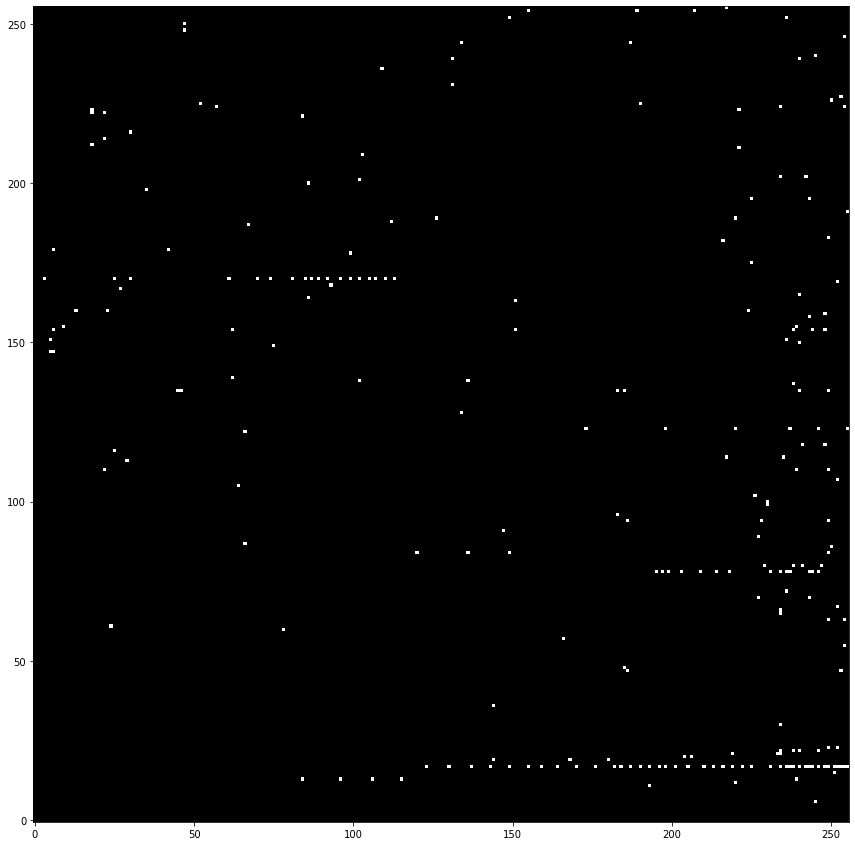

In [19]:
from matplotlib import pyplot as plt 
for i in range(len(order_books)):
    plt.figure(figsize=(20, 15)) 
    plt.imshow(m[1,i], cmap='gray', vmin=0, vmax=1, origin='lower')
    plt.savefig(f"images/{str(i).zfill(5)}.png")
    plt.close()    


In [ ]:
dataset = OrderBooksDataSequenceDatasetV1(
    order_books, amount_best_bins=AMOUNT_BEST_BINS, amount_indices=AMOUNT_INDICES, price_diff_best_bins=PRICE_DIFF_BEST_BINS, price_diff_indices=PRICE_DIFF_INDICES
)

dataset.save("new")
r = OrderBooksDataSequenceDatasetV1.load("new")

x, y, idx, metadata = r
m = np.zeros(shape=(2, len(x['bids_sparse']), 246, 246))
for i in range(len(x['bids_sparse'])):
    m[0, i, x['bids_sparse'][i][0], x['bids_sparse'][i][1]] = x['bids_sparse'][i][2]
    m[1, i, x['asks_sparse'][i][0], x['asks_sparse'][i][1]] = x['asks_sparse'][i][2]

dataset._legacy_save("old")
rr = OrderBooksDataSequenceDatasetV1._legacy_load("old")
x_, y_, idx_, metadata_= rr
m_ = np.zeros(shape=(2, len(x_), 246, 246))
for i in range(len(x_)):
    m_[0, i, :] = x_[i]['bids_sparse'].toarray()
    m_[1, i, :] = x_[i]['asks_sparse'].toarray()

assert np.all(y_ == y)
assert metadata == metadata_
assert np.all(idx_ == idx)
np.all(m == m_)
print("done", idx[0])

In [ ]:
chunks = all_chunks[0].chunks(chunk_size=5000)
for chunk in chunks:
    order_books = source.get_all_order_books(chunk.keys)

    dataset = OrderBooksDataSequenceDatasetV1(
        order_books, amount_best_bins=AMOUNT_BEST_BINS,
        amount_indices=AMOUNT_INDICES,
        price_diff_best_bins=PRICE_DIFF_BEST_BINS,
        price_diff_indices=PRICE_DIFF_INDICES
    )
    if dataset.validate():
        meta_data = dataset.metadata()
        file_name = f'{meta_data["start_day"]}-{meta_data["first_timestamp"]}' \
                    f'-{meta_data["last_timestamp"]}.tar.gz'
        dataset.save(file_name)
        print(f"{file_name} saved")
    else:
        print(f"Dataset {dataset.metadata()} is not valid")


In [ ]:
len(price_diff_bins_new,)

In [ ]:
def sparse_to_list_of_tuples(sparse_matrix):
    nz = sparse_matrix.nonzero()
    m = sparse_matrix[nz]
    

x_sparse_bids = []
x_sparse_asks = []

for idx, elem in enumerate(x):
    x_bids_current = sparse_to_list_of_tuples(
        elem['bids_sparse']
    )
    x_asks_current = sparse_to_list_of_tuples(
        elem['asks_sparse']
    )

    x_sparse_asks.append(x_asks_current)
    x_sparse_bids.append(x_bids_current)


In [ ]:
np.save(file="x", arr=np.array(x_sparse_asks, dtype=object), allow_pickle=True)

In [ ]:
np.load("x.npy", allow_pickle=True)

In [ ]:
import ujson 

In [ ]:
ujson.dump(x_sparse_bids, open("x", "w"))

In [ ]:
x_sparse_bids

In [ ]:
dataset.validate()

In [ ]:
1634720444 - 1634719706

In [ ]:
from __future__ import annotations
import concurrent
import datetime
import traceback
import zlib
from abc import abstractmethod, ABC
from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from multiprocessing import Pool

from typing import List, Dict

import dataclasses

import boto3
import msgpack
import numpy as np
import pandas as pd
from scipy import sparse

ACCEPTABLE_PRICE_DIFF = 0.03


In [ ]:
with open("/home/kamil/Downloads/1634719706", "rb") as f :
    object_content = f.read()
    decompressed_bytes = zlib.decompress(object_content)
    raw_dict = msgpack.unpackb(
        decompressed_bytes
    )

In [ ]:
x = raw_dict[b'asks']

In [ ]:
with open("/home/kamil/Downloads/1634720444", "rb") as f :
    object_content = f.read()
    decompressed_bytes = zlib.decompress(object_content)
    raw_dict = msgpack.unpackb(
        decompressed_bytes
    )

In [ ]:
raw_dict[b'asks'] == x

In [ ]:
60 * 24


In [ ]:
import os 
from src.model import OrderBooksDataSequenceDatasetV1, S3OrderBookDataSource
base_dataset_dir = "output/output/"

datasets = []

def read_f(filepath):        
    d = datasets.append(OrderBooksDataSequenceDatasetV1.load(filepath))    
    print(f"{filepath} loaded")
    return d 
   
    
from multiprocessing import Pool 

with Pool(processes=16) as pool:
    results = pool.map(
        read_f,
        [os.path.join(base_dataset_dir, f) for f in os.listdir(base_dataset_dir)]
    )
        




In [ ]:
with open("data/price_diff_best_bins_new.bin", "wb") as f:
    pickle.dump(obj=price_diff_bins_new, file=f)